# Exploratory Analysis
This notebook just contains misc data exploring.
Run the snakemake workflow prior to this notebook.

In [1]:
DATA_DIR = "/media/jack/odisk/data/LAA/Homosapiens-SINGLEPROTEIN-1100"

## Setup

In [8]:
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Plot Promiscuity Degree (PD) Data
Promiscuity Degree = Number of unique targets a given ligand (i.e., compound) was active against. This is the same definition used in https://pubs.acs.org/doi/10.1021/acsomega.8b02998

In [3]:
activity_df = pl.read_csv(os.path.join(DATA_DIR, "activities", "activity_info.tsv"), separator="\t")
assay_df = pl.read_csv(os.path.join(DATA_DIR, "assays", "assay_info.tsv"), separator="\t")

In [4]:
joined = activity_df.join(assay_df, on="assay_id", how="inner")
unique_pairs = joined.select(["molregno", "tid"]).unique()
pd_df = (
    unique_pairs
    .group_by("molregno")
    .agg(pl.count("tid").alias("promiscuity_degree"))
)

<Axes: xlabel='promiscuity_degree', ylabel='Count'>

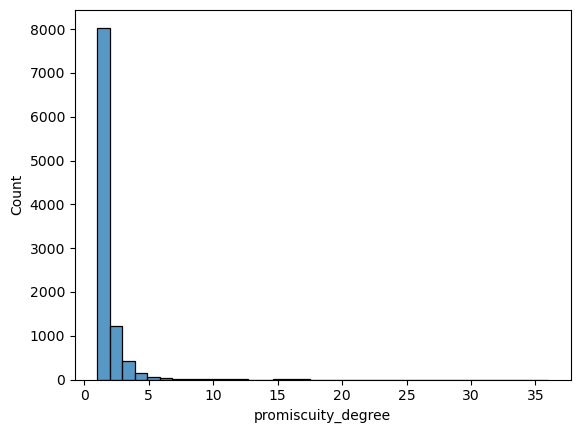

In [5]:
sns.histplot(pd_df, x="promiscuity_degree", bins=max(pd_df["promiscuity_degree"]))

In [6]:
breaks = [1, 4]
labels = ["1", "2-4", "≥5"]
pd_df = pd_df.with_columns(pl.col("promiscuity_degree").cut(breaks=breaks, labels=labels).alias("PD_bin"))
bin_counts = pd_df["PD_bin"].value_counts(sort=False)
bin_counts

PD_bin,count
cat,u32
"""1""",8036
"""2-4""",1803
"""≥5""",156


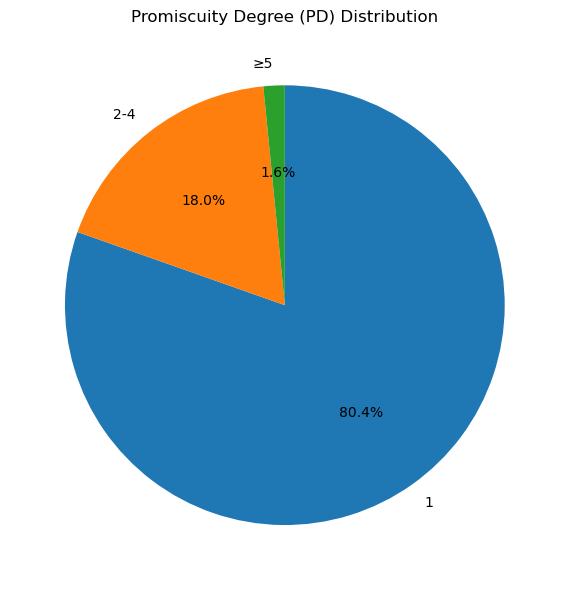

In [7]:
pie_labels, pie_counts = bin_counts["PD_bin"], bin_counts["count"]
plt.figure(figsize=(6, 6))
plt.pie(
    pie_counts,
    labels=pie_labels,
    autopct='%1.1f%%',
    startangle=90, 
    counterclock=False
)
plt.title("Promiscuity Degree (PD) Distribution")
plt.tight_layout()
plt.show()